# From the article [Text Analytics](https://link.springer.com/article/10.1186/s41039-018-0073-0)
# Quoting the article, the rule based classifier marks sentences as described:
1.
Pattern matching: Phrase that matches with “should”, “could”, “include”, “could have” or some with similar intent phrases are indicators of suggestions. We came up with a list of phrases, a thesaurus through empirically observing students’ comments, similar to [Brun and Hagege](https://www.cicling.org/2013/rcs/Suggestion%20Mining_%20Detecting%20Suggestions%20for%20Improvement%20in%20Users_%20Comments.pdf) (2013).

2.
POS tagged: Modal verbs (MD) are followed by a verb (VB, VBZ, VBP). The task of the speech tagging is performed using NLTK ([Bird et al.](https://dl.acm.org/citation.cfm?id=1717171&preflayout=flat) 2009).

3.
POS tagged extended: Tag list includes noun plural (NNS) and proper noun singular (NNP) as described by [Marcus et al.](https://repository.upenn.edu/cgi/viewcontent.cgi?article=1246&context=cis_reports) (1993).

In [3]:
import mysql.connector
import nltk
from mysql.connector import errorcode

import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

############### Connect
config = {
    'user': 'readonly',
    'password': 'readpassword',
    'host': 'peerlogic.csc.ncsu.edu',
    'port': '3306',
    'raise_on_warnings': True,
    'database': 'data_warehouse',
}
# cnx = mysql.connector.connect(**config)
# cursor = cnx.cursor()

################# Query

# query = ("SELECT id, comment FROM answers "
#         "WHERE comment LIKE '%could%' OR comment LIKE '%should%' OR comment LIKE 'suggestion';")
# query = ("SELECT id, comment FROM answers")
# cursor.execute(query)


In [48]:
#### Write sentences to CSV file
count = 0
done = False
import csv
with open('sample_output.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(["Sentence", "Label"])
    for (id, comment) in cursor:
        if comment == None: # Ignore empty comments
            continue
        sentTok = nltk.sent_tokenize(comment)
        for sentence in sentTok:
            if count == 100: # Set the number of sentences to write
                done = True
                break
            if len(sentence) == 1 or len(sentence) == 2:
#                 print(sentence, '\n')
                continue
#             print(sentence, '\n')
            ######## UNCOMMENT BELOW TO WRITE SENTENCES TO CSV FILE
#             writer.writerow([sentence])
            ######## 
#         print(sentence, '\n')
#         output.write(text + '\n')
            count += 1
        if done:
            break

# for (id, comment) in cursor:
#     with open('labeled_sentences.csv', newline = '\n') as csvfile:
#         writer = csv.writer(csvfile, delimiter = '\n', quotechar = '|', quoting = csv.QUOTE_MINIMAL)
#         for count in range(10):
#             count += 1
#             writer.writerow(cursor)

In [4]:
#### Print sentences, this is example input, actual data printed to CSV file ####
numPrint = 0
endPrint = False
for (id, comment) in cursor:
    if comment == None: # Ignore empty comments
        continue
    sentTok = nltk.sent_tokenize(comment)
    for sentence in sentTok:
#         print('{', numPrint, '}', sentence, '\n')
        numPrint += 1
        if numPrint == 10:
            endPrint = True
            break
    if endPrint:
        break

In [13]:
######### Read in the dataset to use for classifier
df = pd.read_csv("suggestions_data.csv", engine = 'python', na_values = ['no info', '.', ' ', 'NaN'])
df.fillna(3, inplace=True)
# df = pd.read_csv("suggestions_data_tweets.csv", engine = 'python');
# df.fillna(-1, inplace=True)

print(df.dtypes)

is_prompt_exists    object
comments            object
Unnamed: 2          object
Unnamed: 3          object
Unnamed: 4          object
dtype: object


Total number of suggestions found: 323
[[534 110]
 [143 213]]


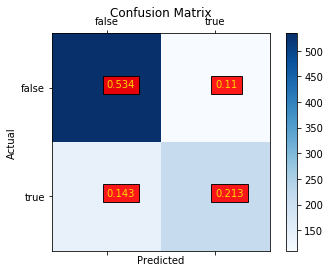

             precision    recall  f1-score   support

      false       0.79      0.83      0.81       644
       true       0.66      0.60      0.63       356

avg / total       0.74      0.75      0.74      1000

True Negative: 534
False Negative: 143
True Positive: 213
False Positive: 110


In [14]:
# print(df.head(5))
# print(df['is_prompt_exists'].dtypes)
# a = pd.to_numeric(df['is_prompt_exists'][1])
# print(a + 3)
# print(df['is_prompt_exists'][1])
# print(df['comments'].dtypes)

##################### Tests the input CSV file that was read into Pandas dataframe
loop = 0
count = 0
numComments = 0
suggestions_per_comment = []
end = len(df) # 16003 in length, takes awhile to process (50 seconds aprox.)
end = 1000 # More managable for quick tests
labels = []
predictions = []
for loop in range(end):
    comment = df['comments'][loop]
    prompt = df['is_prompt_exists'][loop]
    ## Comment below condition out for non-object label datasets
    if isinstance(comment, str) == False or (prompt != '1' and prompt != '-1'):
        continue
    wordTok = nltk.word_tokenize(comment)
    words = nltk.pos_tag(wordTok)
    modalVerb = False
    foundSuggestion = False
    for word in words:
#         if word[1] == "NNS":
#             count += 1
#             foundSuggestion = True
#             break
#         elif word[1] == "NNP":
#             count += 1
#             foundSuggestion = True
#             break
        if word[1] == "MD":
            modalVerb = True
            continue
        elif word[1] == "VB":
            if modalVerb:
                count += 1
                foundSuggestion = True
                break
        elif word[1] == "VBZ":
            if modalVerb:
                count += 1
                foundSuggestion = True
                break
        elif word[1] == "VBP":
            if modalVerb:
                count += 1
                foundSuggestion = True
                break
        elif word[1] == ".": #Modal Verbs: should, could, can, could
            phraseList = {"have more", "suggestion", "perhaps", "better if"}
            endSentence = False
            for phrase in phraseList:
                if (phrase in comment):
                    count += 1
                    foundSuggestion = True
                    endSentence = True
                    break
            if endSentence:
                break
        modalVerb = False
    actual = df['is_prompt_exists'][loop]
    if (foundSuggestion):
        predictions.append(1)
    else:
        predictions.append(0)
    if (actual == '1' or actual == 1.0):
        labels.append(1)
    else:
        labels.append(0)
    suggestions_per_comment.append(count)
    count = 0
    numComments += 1
#     if (numComments % 500 == 0): # For checking progress at 500 step milestones
#         print(numComments)
    ####### END
print("Total number of suggestions found:", sum(suggestions_per_comment))
# print("Ls:", labels)
# print("Ps:", predictions)
ls = ['false', 'true']
cm = confusion_matrix(labels, predictions)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues) # Bar coloring
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + ls)
ax.set_yticklabels([''] + ls)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.text(s = round(cm[0][0]/end, 3), x = 0, y = 0, color = "gold",
         bbox=dict(facecolor='red', alpha=0.9))
plt.text(s = round(cm[1][1]/end, 3), x = 1, y = 1, color = "gold",
         bbox=dict(facecolor='red', alpha=0.9))
plt.text(s = round(cm[1][0]/end, 3), x = 0, y = 1, color = "gold",
         bbox=dict(facecolor='red', alpha=0.9))
plt.text(s = round(cm[0][1]/end, 3), x = 1, y = 0, color = "gold",
         bbox=dict(facecolor='red', alpha=0.9))
plt.show()
print(classification_report(labels, predictions, target_names = ls))
print("True Negative:", cm[0][0])
print("False Negative:", cm[1][0])
print("True Positive:", cm[1][1])
print("False Positive:", cm[0][1])

# [F-Score Metrics](https://en.wikipedia.org/wiki/F1_score)

#### Precision: 
Number of true positives/negatives over total found positives/negatives respectively. This describes how acurately the classifier had labeled the positives and negatives.
#### Recall:
Number of true positives over total found true positives + false negatives. These two categories are considered the relevant instances. The recall for the false section is calculated as the true negatives over the total found false positive/true negative section.
#### F1-Score:
The harmonic mean of precision and recall. The F1-Score is a measure of a test's accuracy. Score ranges from 1 (high) and 0 (low).
##### Note: Sample is not randomly obtained, it runs in order of the csv file from 1 to specified end point.
## For the "suggestions_data.csv" dataset:
### The results of running a small sample of 1000 is as follows:
#### With Rule 3:
                precision    recall  f1-score   support

      false       0.84      0.20      0.33        644
       true       0.39      0.93      0.55        356
    avg / total   0.68      0.46      0.41       1000

True Negative: 130,
False Negative: 24,
True Positive: 332,
False Positive: 514

#### Without Rule 3:
                precision    recall  f1-score   support

      false       0.79      0.83      0.81       644
       true       0.66      0.60      0.63       356
    avg / total   0.74      0.75      0.74      1000
    
True Negative: 534,
False Negative: 143,
True Positive: 213,
False Positive: 110


### The results of running the full sample is as follows:
#### With Rule 3:
                precision    recall  f1-score   support

      false       0.80      0.05      0.09      6226
       true       0.38      0.98      0.54      3642
    avg / total   0.64      0.39      0.26      9868

True Negative: 288,
False Negative: 72,
True Positive: 3570,
False Positive: 5938

#### Without Rule 3:
                precision    recall  f1-score   support

      false       0.81      0.76      0.78      6226
       true       0.63      0.70      0.66      3642
    avg / total   0.74      0.74      0.74      9868

True Negative: 4720,
False Negative: 1091,
True Positive: 2551,
False Positive: 1506

## For the "suggestions_data_tweets.csv" dataset:
### The results of running the full 3000 sample is as follows:
#### With Rule 3:
                precision    recall  f1-score   support

      false       0.91      0.01      0.01      2762
       true       0.08      0.99      0.15       238
    avg / total   0.84      0.09      0.02      3000

True Negative: 20,
False Negative: 2,
True Positive: 236,
False Positive: 2742

#### Without Rule 3:
                precision    recall  f1-score   support

      false       0.94      0.84      0.89      2762
       true       0.18      0.40      0.25       238
    avg / total   0.88      0.81      0.84      3000

True Negative: 2327,
False Negative: 142,
True Positive: 96,
False Positive: 435

In [5]:
################## Start Classifier
count = 0
numComments = 0
suggestions_per_comment = []
for (id, comment) in cursor:
    if comment == None:
        continue
#     words = nltk.word_tokenize(i)
#     tagged = nltk.pos_tag(words)
#     print(comment, "\n-----------------------------------------\n")
    sentTok = nltk.sent_tokenize(comment)
#     print(sentTok, "\n")
    modalVerb = False
    labeled_comment = [] # List of comments with suggestions labeled
    for sentence in sentTok:
        wordTok = nltk.word_tokenize(sentence)
#         print(wordTok, "\n")
        words = nltk.pos_tag(wordTok)
        prevC = count # TEST
#         print(words, "\n")
        for word in words:
            if word[1] == "NNS":
                count += 1
#                 print("Rule 3 (Nouns):", sentence, '\n')
#                     print(word)
                sentence += "(R:3)"
                labeled_comment.append(sentence)
                break
            elif word[1] == "NNP":
                count += 1
#                 print("Rule 3 (Nouns):", sentence, '\n')
#                     print(word)
                sentence += "(R:3)"
                labeled_comment.append(sentence)
                break
            elif word[1] == "MD":
#                     print(word)
                modalVerb = True
                continue
            elif word[1] == "VB":
                if modalVerb:
#                         print(word)
                    count += 1
#                     print("Rule 2 (Verbs):", sentence, '\n')
                    sentence += "(R:2)"
                    labeled_comment.append(sentence)
                    break
            elif word[1] == "VBZ":
                if modalVerb:
#                         print(word)
                    count += 1
#                     print("Rule 2 (Verbs):", sentence, '\n')
                    sentence += "(R:2)"
                    labeled_comment.append(sentence)
                    break
            elif word[1] == "VBP":
                if modalVerb:
#                         print(word)
                    count += 1
#                     print("Rule 2 (Verbs):", sentence, '\n')
                    sentence += "(R:2)"
                    labeled_comment.append(sentence)
                    break
            elif word[1] == ".": #Modal Verbs: should, could, can, could
                phraseList = {"have more", "suggestion", "perhaps", "better if"}
                original_sentence = sentence
                endSentence = False
                for phrase in phraseList:
                    sentence = (' '.join(wordTok)).lower()
#                     print(sentence, '\n')
                    if (phrase in sentence):
                        count += 1
#                         print("Rule 1 (Pattern Matching):", sentence, '\n')
                        original_sentence += "(R:1)"
                        labeled_comment.append(original_sentence)
                        endSentence = True
                        break
                if endSentence:
                    break
                original_sentence += "(NONE)" # At the end of sentence and no suggestion has been found
                labeled_comment.append(original_sentence)
#             if prevC < count:
#                     print(sentence, '\n')
            modalVerb = False
    suggestions_per_comment.append(count)
#     print(count)
#     print('\n\n')
#     if (count < 3):
#         print("Suggestions:", count)
#         print(labeled_comment, '\n')
#         print(comment, '\n\n')
    count = 0
    numComments += 1
    if numComments == 300:
        break
################## End Classifier
print("Total number of suggestions found:", sum(suggestions_per_comment))
print("Number of unique suggestion counts:", len(set(suggestions_per_comment)))
print("Average number of suggestions per comment:", np.average(suggestions_per_comment))
# print(set(suggestions_per_comment))
# print(suggestions_per_comment)
#### Testing
sentence = "idea"
s1 = nltk.word_tokenize(sentence)
s2 = nltk.pos_tag(s1)
# print('\n', s2)
#### Testing

#Close
cnx.close()

Total number of suggestions found: 778
Number of unique suggestion counts: 12
Average number of suggestions per comment: 2.5933333333333333


dict_keys([3, 2, 0, 1, 8, 6, 4, 9, 5, 7, 10, 12])
dict_values([67, 92, 13, 66, 2, 12, 27, 1, 13, 5, 1, 1])


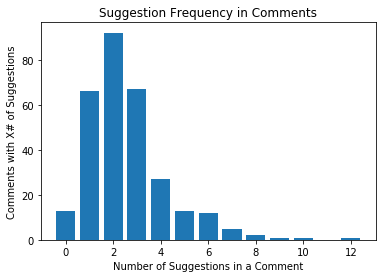

In [6]:
################# Bar Chart Visualization
a = suggestions_per_comment
d = {x:a.count(x) for x in a}
x, y = d.keys(), d.values()

# print(a)
print(x)
print(y)

plt.bar(x, y, label = 'Bars1')
# The X-Axis indicates the range of suggestion quantity present in the comments
plt.xlabel('Number of Suggestions in a Comment')
# The Y-Axis indicates how many comments have the number of suggestions indicated by the X-Axis
plt.ylabel('Comments with X# of Suggestions')
plt.title('Suggestion Frequency in Comments')
plt.show()